In [68]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [69]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [70]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [71]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [72]:
!head -2 ../../FinalProject/hein-daily/sample/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [73]:
!cat ../../FinalProject/hein-daily/Sample/speeches_097.txt | wc -l

  283399


In [74]:
data_path = '../../FinalProject/hein-daily/Sample'

In [75]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [76]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

#### TODO:

- Why is this taking so much time?
- Subset on word cound here?
- Make sampling replicable: random seed + random array of proper length

In [77]:
reload(load_data)
start_time = time.time()
# remove p if want to run for the full speech file
descr = load_data.load_descr_data('../data/QA/full_descr.txt', p=0.3)
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 6.7 seconds to create the dictionary


In [78]:
next(iter(descr.items()))

('970000005',
 {'date': '19810105',
  'char_count': '201',
  'word_count': '34',
  'speakerid': '97105301.0',
  'Party': 'R',
  'Congress': '97',
  'Chamber': 'S',
  'State': 'IL',
  'Ethnicity': 'W',
  'Age': '63.0',
  'Age_lt_med': '0.0',
  'NonWhite': '0.0',
  'Female': '0.0',
  'speaker': 'Mr. PERCY',
  'Full Name': 'PERCY, CHARLES',
  'match': 'exact',
  'check': 1})

In [79]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [80]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

In [92]:
party_dummy = []
for p in range(len(party)):
    if party[p] == 'D':
        party_dummy.append(1)
    elif party[p] == 'R':
        party_dummy.append(0)
    else:
        party_dummy.append(-1)
len(party_dummy)

283399

In [93]:
np.unique(np.array(party_dummy), return_counts=True)

(array([-1,  0,  1]), array([216868,  34250,  32281]))

### Data QA

In [83]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216551
1,0,65477
2,1,1371


Target group number of speeches by party:
D: 	 664
I: 	 0
N: 	 0
NA: 	 -216551
R: 	 707

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216551
1,0,64037
2,1,2811


Target group number of speeches by party:
D: 	 2405
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 361

 Age
Overall speech counts:


,Category,Count
0,-1,216551
1,0,43720
2,1,23128


Target group number of speeches by party:
D: 	 12400
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 10683


In [84]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19810616
char_count 1326
word_count 250
speakerid 97111540.0
Party D
Congress 97
Chamber H
State CO
Ethnicity W
Age 42.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Mrs. SCHROEDER
Full Name SCHROEDER, PATRICIA
match exact
check 1

Mr. Speaker. I hate to say this. but ever since I got here. I have been waiting for a motherhood issue. This Is it. I can not imagine any mother voting any way but for the resolution. I was very. very. very surprised by the administrations action on infant formula. I commend the committee for reporting this resolution because I think it is very important that the legislative body go on record as saying to tihe world that we think the administration made a mistake. I think it will send a special signal to the world right now because this body is tending to want to act like the administrations rowing team on every issue and if we are willing to stand tip and say on this issue we think they made a mistake. we have the courage to say i

In [85]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
date 19810408
char_count 2012
word_count 318
speakerid 97105561.0
Party R
Congress 97
Chamber S
State SD
Ethnicity ME
Age 59.0
Age_lt_med 0.0
NonWhite 1.0
Female 0.0
speaker Mr. ABDNOR
Full Name ABDNOR, JAMES
match exact
check 1

Mr. President. today Senator PRESSLER and I are introducing legislation to reauthorize the Belle Fourche project in South Dakota as a unit of the PickSloan Missouri Basin program. The Belle Fourche project went into operation In 1908. and 73 years later most of the structures in the irrigation project have reached their design life and are badly in need of repair. In fact. there have been five accidental deaths In the last 5 years that might have been averted with the rroject improvements to be provided through this legislation. For example. because of the absence of handrails district employees have actually slipped from the structures and fallen into the canals. Modernization and Improvements of the 57.000acre project will produce signifi

In [86]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 19811216
char_count 73
word_count 16
speakerid 97108191.0
Party D
Congress 97
Chamber S
State AZ
Ethnicity W
Age 45.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. DECONCINI
Full Name DECONCINI, DENNIS
match exact
check 1

I am advised there Is no revenue loss. at least no one here knows of any.


## Split into train, validate, test

### Filter on party if necessary

In [87]:
# reload(load_data)
# all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
# len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [88]:
# reload(explore_data)
# explore_data.get_counts(gender_d)

### Split into train/val/test

### Split by congress

In [89]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [97]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, party_dummy, descr)

Training split: 10442 ones and 10399 zeroes
Training speech list size: 20841
Training target list size: 20841
Validation split: 3480 ones and 3466 zeroes
Validation speech list size: 6946
Validation target list size: 6946
Test split: 3482 ones and 3468 zeroes
Test speech list size: 6950
Test target list size: 6950


In [98]:
sum(train_target), sum(val_target), sum(test_target)

(10442, 3480, 3482)

In [99]:
# number of speeches under 30 words
sum(np.array(age)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

5724

In [100]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19811211
char_count 274
word_count 51
speakerid 97106510.0
Party D
Congress 97
Chamber H
State TX
Ethnicity W
Age 59.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. WHITE
Full Name WHITE, RICHARD
match exact
check 1

Mr. Speaker. If the gentleman will yield. I do not know that it has. This is a routine procedure. We have gone through the hearing. The committee has reported out the bUi. Of course. It.. still would have to go through Rules before the bill could come before the full House.


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [101]:
reload(explore_data)

<module 'helpers.explore_data' from '/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification/helpers/explore_data.py'>

In [102]:
explore_data.get_num_words_per_sample(train)

177.0

In [103]:
explore_data.get_num_words_per_sample(val)

177.0

In [104]:
explore_data.get_num_words_per_sample(test)

177.0

Speech length percentiles
    0     10    20    30     40     50     60     70     80     90      100
0  31.0  41.0  58.0  84.0  123.0  177.0  241.0  332.0  467.0  749.0  8421.0


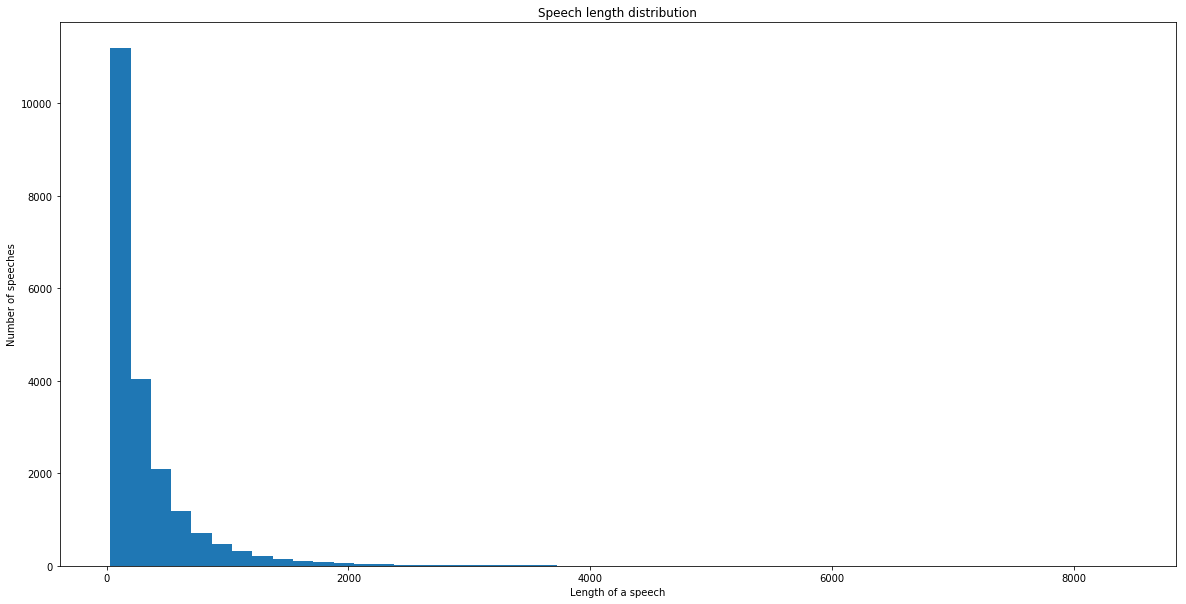

In [105]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [106]:
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

4168

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'it', 'we', 'on', 'be', 'have', 'not', 'as', 'are', 'by', 'with', 'will', 'mr', 'from', 'would', 'has', 'our', 'which', 'was', 'an', 'president', 'at', 'or', 'my', 'they', 'but', 'their', 'been', 'he', 'all', 'his', 'do', 'if', 'bill', 'there', 'who', 'these', 'amendment', 'one', 'committee', 'more', 'time']


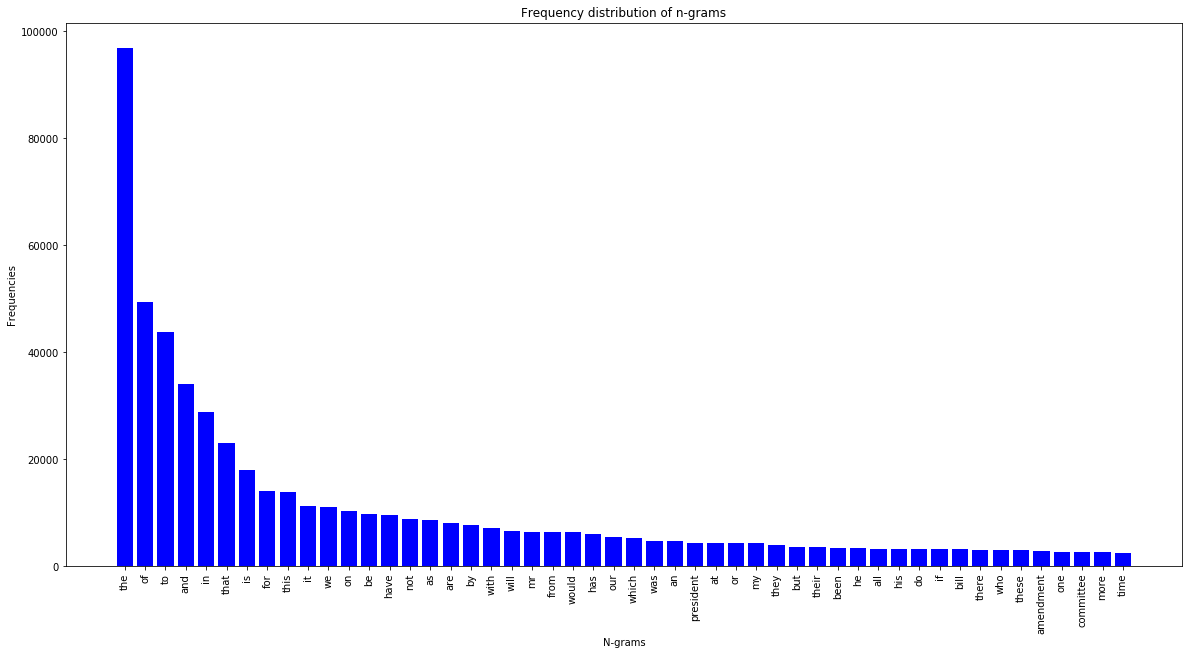

In [107]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'that the', 'on the', 'for the', 'and the', 'by the', 'mr president', 'to be', 'with the', 'of this', 'mr speaker', 'we are', 'we have', 'that we', 'will be', 'in this', 'that is', 'has been', 'from the', 'would be', 'the senate', 'the united', 'is the', 'united states', 'at the', 'the gentleman', 'have been', 'do not', 'is not', 'going to', 'the house', 'the senator', 'of our', 'there is', 'senator from', 'my colleagues', 'as the', 'the committee', 'the federal', 'the president', 'this is', 'the bill', 'this bill', 'one of', 'want to', 'that it', 'under the']


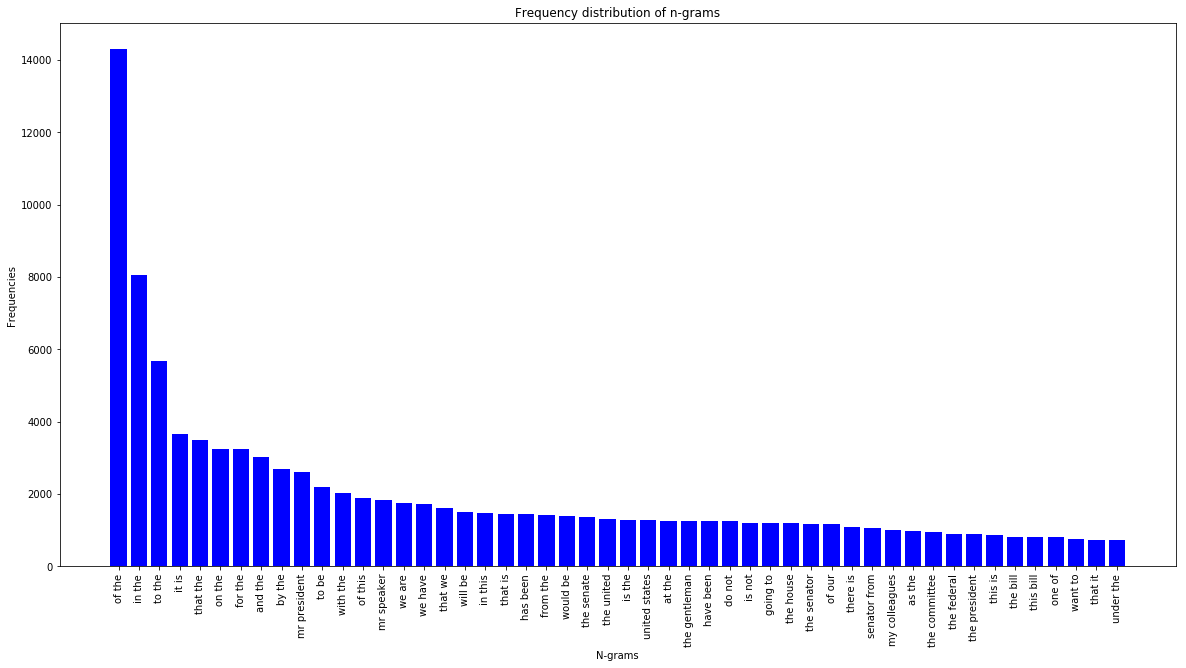

In [108]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'the senator from', 'would like to', 'the gentleman from', 'one of the', 'the soviet union', 'are going to', 'chairman of the', 'of the united', 'ask unanimous consent', 'the department of', 'in the record', 'is going to', 'as well as', 'percent of the', 'unanimous consent that', 'there is no', 'member of the', 'the fact that', 'the committee on', 'members of the', 'the federal government', 'of the house', 'the american people', 'that it is', 'in this country', 'my colleagues to', 'in order to', 'of the senate', 'part of the', 'it is not', 'going to be', 'we are going', 'be able to', 'that we are', 'we do not', 'of the committee', 'some of the', 'urge my colleagues', 'that we have', 'it would be', 'the people of', 'the secretary of', 'mr president the', 'of my colleagues', 'in the house', 'in the united', 'mr president ask', 'thank the gentleman', 'printed in the']


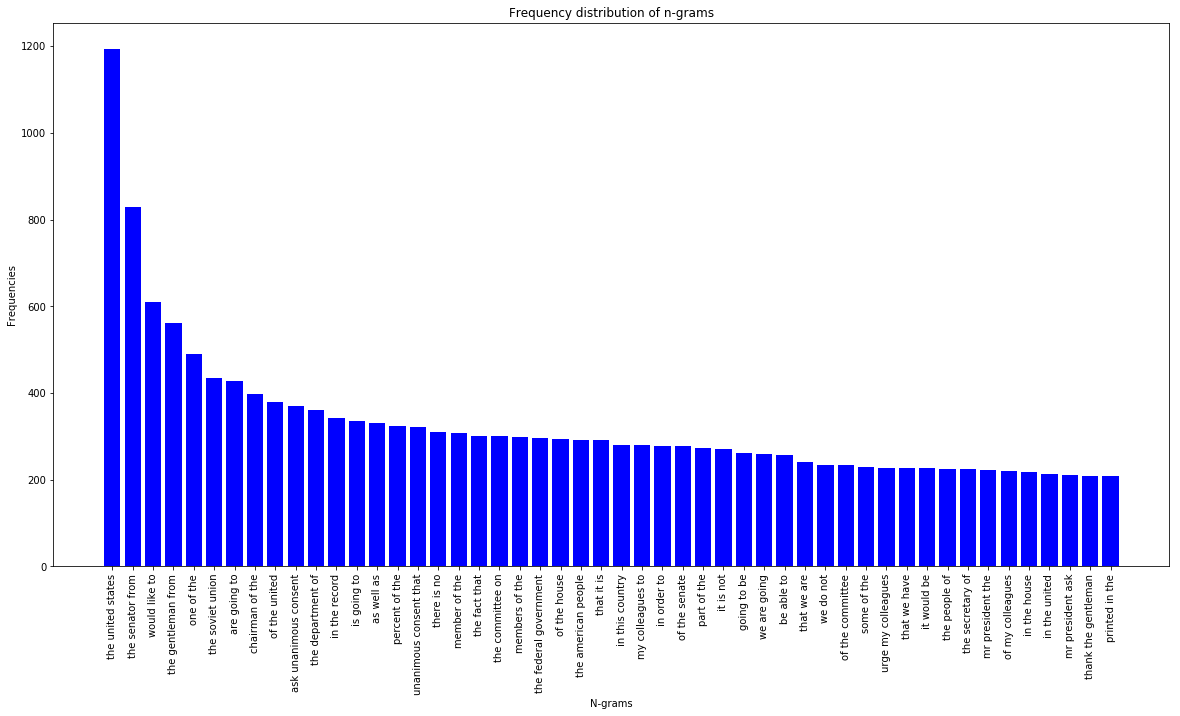

In [109]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [110]:
congress = set([str(i) for i in range(97,115)])

In [111]:
len(train)

20841

In [112]:
descr['1110063404']

{'date': '20090930',
 'char_count': '1356',
 'word_count': '244',
 'speakerid': '111118281.0',
 'Party': 'R',
 'Congress': '111',
 'Chamber': 'S',
 'State': 'TN',
 'Ethnicity': 'W',
 'Age': '70.0',
 'Age_lt_med': '0.0',
 'NonWhite': '0.0',
 'Female': '0.0',
 'speaker': 'Mr. ALEXANDER',
 'Full Name': 'ALEXANDER, LAMAR',
 'match': 'exact',
 'check': 1}

In [113]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 97 top 5 (3, 3) ngrams are:
the united states
the senator from
would like to
the gentleman from
one of the
--------------------


## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [114]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [115]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)

Total vocabulary size: 157288
Number of stop words 1320512

Top 5 ngrams by differentiating score:
mr president 	 783.6
president 	 399.7
president ask 	 393.6
the senate 	 298.7
senate 	 295.7

Bottom 5 ngrams by differentiating score:
comrades 	 0.0
are completely 	 0.0
attaining 	 0.0
island sound 	 0.0
with financial 	 0.0


In [116]:
len(train), len(val), len(test)

(20841, 6946, 6950)

In [117]:
train_vec.shape, val_vec.shape, test_vec.shape

((20841, 20000), (6946, 20000), (6950, 20000))

### Saving processed files

In [118]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [119]:
data_path = '../../FinalProject/saved_files'

In [120]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [121]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [122]:
train_vec.shape, val_vec.shape, test_vec.shape

((20841, 20000), (6946, 20000), (6950, 20000))

In [123]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [124]:
sum(train_target), sum(val_target), sum(test_target)

(10442, 3480, 3482)

In [125]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [126]:
sum(train_target), sum(val_target), sum(test_target)

(10442, 3480, 3482)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [127]:
logs_base_dir = '../../FinalProject/logs'

In [128]:
ngram_model_params = {
    'model': 'ngram',
    'log_dir': logs_base_dir,
    'learning_rate': 1e-3,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [129]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), **ngram_model_params)

Train on 20841 samples, validate on 6946 samples
Epoch 1/1000
 - 23s - loss: 0.6334 - acc: 0.6499 - val_loss: 0.6175 - val_acc: 0.6362
Epoch 2/1000
 - 22s - loss: 0.4980 - acc: 0.7878 - val_loss: 0.6054 - val_acc: 0.6463
Epoch 3/1000
 - 22s - loss: 0.3904 - acc: 0.8530 - val_loss: 0.6203 - val_acc: 0.6447
Epoch 4/1000
 - 23s - loss: 0.3148 - acc: 0.8863 - val_loss: 0.6514 - val_acc: 0.6418
Validation accuracy: 0.6418082349210454, loss: 0.6514308869306683


## Model evaluation

In [130]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

4458

Confusion matrix, without normalization
[[2062 1404]
 [1084 2396]]


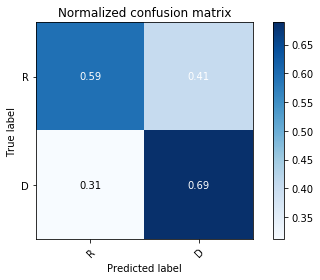

In [132]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['R', 'D']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

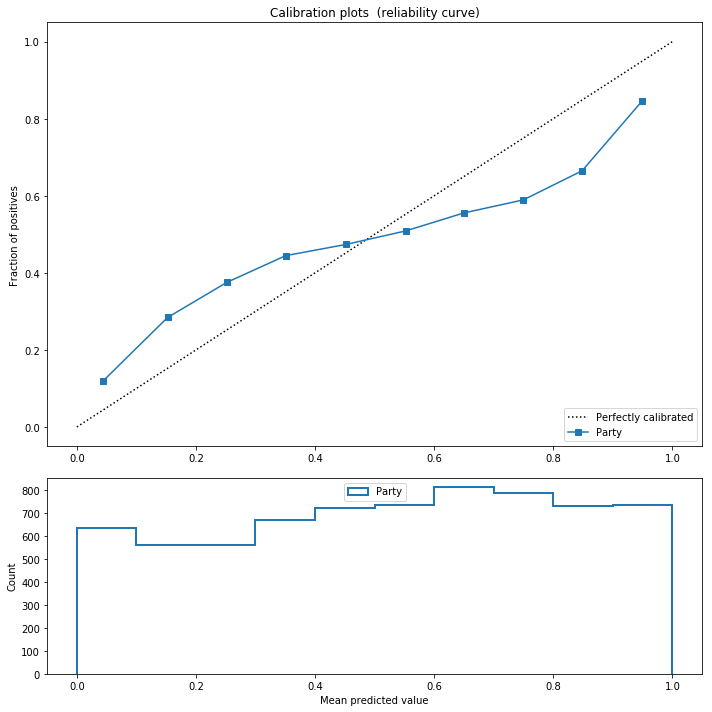

In [133]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Party')

In [134]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.29945292254534983

In [135]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(2080, 2080, 2080)

In [136]:
descr_df = pd.read_csv('../data/QA/full_descr.txt', sep="|", index_col=0)
descr_df.shape

/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2914464, 16)

In [137]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs, val_ids, descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.079474       0.087358  58.324787  0.520156   0.563685    232.456109


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.12,0.29,0.94,0.60,0.59,1.08
0.6,0.34,0.44,0.91,0.94,1.00,1.29
1.0,0.37,0.77,0.91,1.27,1.20,1.70


In [138]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
president ask unanimous consent 	 93.1
president ask unanimous 	 88.4
mr president ask unanimous 	 84.2
mr president ask 	 73.5
unanimous consent that 	 69.1
ask unanimous consent that 	 68.2
ask unanimous consent 	 64.5
mr speaker ask 	 56.4
speaker ask unanimous 	 52.2
mr speaker ask unanimous 	 51.5


bin,1,2,3
ask unanimous consent,376.0,94.0,217.0
ask unanimous consent that,317.0,74.0,158.0
mr president ask,223.0,47.0,72.0
mr president ask unanimous,188.0,31.0,42.0
mr speaker ask,3.0,6.0,107.0
mr speaker ask unanimous,1.0,5.0,93.0
president ask unanimous,197.0,34.0,43.0
president ask unanimous consent,196.0,31.0,40.0
speaker ask unanimous,1.0,5.0,94.0
unanimous consent that,325.0,79.0,160.0


In [139]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the senator from
the united states
ask unanimous consent
unanimous consent that
ask unanimous consent that
of the senate
would like to
the federal government
the department of
mr president ask
--------------------

In 0.6 bin top 10 ngrams:

the united states
the senator from
the department of
would like to
the gentleman from
chairman of the
the soviet union
one of the
are going to
of the united
--------------------

In 1.0 bin top 10 ngrams:

the united states
would like to
the gentleman from
one of the
the department of
of the united
are going to
the senator from
the federal government
chairman of the
--------------------


In [140]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.95):

date                 19810729
char_count               5423
word_count                891
speakerid         9.71099e+07
Party                       D
Congress                   97
Chamber                     H
State                      NY
Ethnicity                   W
Age                        55
Age_lt_med                  0
NonWhite                    0
Female                      0
speaker            Mr. WVEISS
Full Name     WEISS, THEODORE
match                   exact
Name: 970069928, dtype: object

 Mr. Chairman. the only bill that is consonant with national economic justice Is the Udall substitute. I urge its adoption. Mr. Chairman. In todays debate on the Tax Incentive Act of 1981. we are really confronted with the task of choosing between two slightly different versions of voodoo economics. My colleagues will recall that It was Candidate GEORGE HusH who coined the term "voodoo economics" to describe a policy of reducing taxes during a 